# Online Retail Dataset: Customer Segmentation

In this notebook, we'll perform the actual customer segmentation. More
precisely, we'll use our results for the RFM scores to divide the customers
into meaningful segments.

## Imports

In [1]:
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.ticker import AutoMinorLocator
from more_itertools import unique_everseen
from pandas.testing import assert_frame_equal, assert_series_equal

## Read RFM scores

In [2]:
DATA_DIR = Path.cwd().parents[1] / "data"

# File path for dataset
file_path = DATA_DIR / "rfm_scores.csv"
assert file_path.exists(), f"file doesn't exist: {file_path}"
assert file_path.is_file(), f"not a file: {file_path}"

In [3]:
df_rfm = pd.read_csv(
    file_path,
    dtype={
        "CustomerID": "category",
        "Recency": np.int_,
        "Frequency": np.int_,
        "Monetary": np.float_,
        "RScore": "category",
        "FScore": "category",
        "MScore": "category",
        "RFMCell": object,
        "RFMScore": np.float_,
    },
    index_col="CustomerID",
)
df_rfm.head(15)

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,"1,1,5",2.333333
12347,3,7,4310.00,5,5,5,"5,5,5",5.000000
12348,76,4,1797.24,2,4,4,"2,4,4",3.333333
12349,19,1,1757.55,4,1,4,"4,1,4",3.000000
12350,311,1,334.40,1,1,2,"1,1,2",1.333333
12352,37,8,2506.04,3,5,5,"3,5,5",4.333333
12353,205,1,89.00,1,1,1,"1,1,1",1.000000
12354,233,1,1079.40,1,1,4,"1,1,4",2.000000
12355,215,1,459.40,1,1,2,"1,1,2",1.333333


In [4]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 4338 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4338 non-null   int64   
 1   Frequency  4338 non-null   int64   
 2   Monetary   4338 non-null   float64 
 3   RScore     4338 non-null   category
 4   FScore     4338 non-null   category
 5   MScore     4338 non-null   category
 6   RFMCell    4338 non-null   object  
 7   RFMScore   4338 non-null   float64 
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 354.2+ KB


In [5]:
# Categorical columns aren't ordered
df_rfm["RScore"].cat.ordered

False

In [6]:
# Fix categorical columns
score_cols = ["RScore", "FScore", "MScore"]
df_rfm[score_cols] = df_rfm[score_cols].transform(lambda col: col.cat.as_ordered())
del score_cols

In [7]:
# Quick check
df_rfm["RScore"].head()

CustomerID
12346    1
12347    5
12348    2
12349    4
12350    1
Name: RScore, dtype: category
Categories (5, object): ['1' < '2' < '3' < '4' < '5']

## Customer segmentation

Next, we'll divide the customers into segments. Unfortunately, there's no
single way to do this. More precisely, there are several ways to assign
meaning to RFM scores. In this notebook, we'll adopt the approach described
in this [blog post](https://nealanalytics.com/blog/customer-segmentation-using-rfm-analysis/).

Specifically, we'll consider the following 11 segments:
- Champions
- Loyal
- Potential Loyalists
- New Customers
- Promising
- Need Attention
- About to Sleep
- Cannot Lose Them
- At Risk
- Hibernating
- Lost

For a description of these segments, see the blog post mentioned above.

Before continuing, we need to make a few comments. **These segments are far
from perfect.** For instance, we believe some of them are too broad. But
they're the closest thing to a standard that we could find. They're also
discussed in these articles:
- [https://documentation.bloomreach.com/engagement/docs/rfm-segmentation](https://documentation.bloomreach.com/engagement/docs/rfm-segmentation)
- [https://shopup.me/model/rfm-segmentation/](https://shopup.me/model/rfm-segmentation/)
- [https://www.dase-analytics.com/blog/en/rfm-analysis/](https://www.dase-analytics.com/blog/en/rfm-analysis/)

### Champions

Each segment is characterized by a set of values for `RFMCell`. In the case
of "Champions", these values are as follows:

In [8]:
cells_1 = [
    "5,5,5",
    "5,5,4",
    "5,4,5",
    "5,4,4",
    "4,5,5",
    "4,5,4",
    "4,4,5",
]

Labeling customers:

In [9]:
df_rfm["Segment"] = ""

mask = df_rfm["RFMCell"].isin(cells_1)
df_rfm.loc[mask, "Segment"] = "Champions"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12347,3,7,4310.00,5,5,5,"5,5,5",5.000000,Champions
12362,4,10,5226.23,5,5,5,"5,5,5",5.000000,Champions
12364,8,4,1313.10,5,4,4,"5,4,4",4.333333,Champions
12380,22,4,2724.81,4,4,5,"4,4,5",4.333333,Champions
12381,5,5,1845.31,5,4,4,"5,4,4",4.333333,Champions


**NOTE**: This isn't the best way to label customers. After introducing all
segments, we'll solve this problem more efficiently.

### Loyal

This segment is characterized by the following `RFMCell` values:

In [10]:
cells_2 = [
    "5,4,3",
    "4,4,4",
    "4,3,5",
    "3,5,5",
    "3,5,4",
    "3,4,5",
    "3,4,4",
    "3,3,5",
]

Labeling customers:

In [11]:
mask = df_rfm["RFMCell"].isin(cells_2)
df_rfm.loc[mask, "Segment"] = "Loyal"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12352,37,8,2506.04,3,5,5,"3,5,5",4.333333,Loyal
12356,23,3,2811.43,4,3,5,"4,3,5",4.000000,Loyal
12359,58,4,6372.58,3,4,5,"3,4,5",4.000000,Loyal
12360,53,3,2662.06,3,3,5,"3,3,5",3.666667,Loyal
12370,52,4,3545.69,3,4,5,"3,4,5",4.000000,Loyal


### Potential Loyalists

This segment corresponds to the following values of `RFMCell`:

In [12]:
cells_3 = [
    "5,5,3",
    "5,5,2",
    "5,5,1",
    "5,4,2",
    "5,4,1",
    "5,3,3",
    "5,3,2",
    "5,3,1",
    "4,5,3",
    "4,5,2",
    "4,5,1",
    "4,4,2",
    "4,4,1",
    "4,3,3",
    "4,3,2",
    "4,3,1",
    "4,2,3",
    "3,5,3",
    "3,5,2",
    "3,5,1",
    "3,4,2",
    "3,4,1",
    "3,3,3",
    "3,2,3",
]

Labeling customers:

In [13]:
mask = df_rfm["RFMCell"].isin(cells_3)
df_rfm.loc[mask, "Segment"] = "Potential Loyalists"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12384,29,2,585.27,4,2,3,"4,2,3",3.000000,Potential Loyalists
12413,67,3,758.10,3,3,3,"3,3,3",3.000000,Potential Loyalists
12427,22,3,825.80,4,3,3,"4,3,3",3.333333,Potential Loyalists
12465,18,2,742.19,4,2,3,"4,2,3",3.000000,Potential Loyalists
12498,22,3,403.70,4,3,2,"4,3,2",3.000000,Potential Loyalists


### New Customers

For this segment, the `RFMCell` values are

In [14]:
cells_4 = [
    "5,1,2",
    "5,1,1",
    "4,2,2",
    "4,2,1",
    "4,1,2",
    "4,1,1",
    "3,1,1",
]

Labeling customers:

In [15]:
mask = df_rfm["RFMCell"].isin(cells_4)
df_rfm.loc[mask, "Segment"] = "New Customers"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12367,5,1,168.90,5,1,1,"5,1,1",2.333333,New Customers
12391,22,1,460.89,4,1,2,"4,1,2",2.333333,New Customers
12442,4,1,172.06,5,1,1,"5,1,1",2.333333,New Customers
12445,23,1,133.40,4,1,1,"4,1,1",2.000000,New Customers
12452,17,2,430.57,4,2,2,"4,2,2",2.666667,New Customers


### Promising

"Promising" customers are characterized by the following values of `RFMCell`:

In [16]:
cells_5 = [
    "5,2,5",
    "5,2,4",
    "5,2,3",
    "5,2,2",
    "5,2,1",
    "5,1,5",
    "5,1,4",
    "5,1,3",
    "4,2,5",
    "4,2,4",
    "4,1,5",
    "4,1,4",
    "4,1,3",
    "3,1,5",
    "3,1,4",
    "3,1,3",
]

Labeling customers:

In [17]:
mask = df_rfm["RFMCell"].isin(cells_5)
df_rfm.loc[mask, "Segment"] = "Promising"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12349,19,1,1757.55,4,1,4,"4,1,4",3.000000,Promising
12357,34,1,6207.67,3,1,5,"3,1,5",3.000000,Promising
12358,2,2,1168.06,5,2,4,"5,2,4",3.666667,Promising
12374,26,1,742.93,4,1,3,"4,1,3",2.666667,Promising
12375,11,2,457.50,5,2,2,"5,2,2",3.000000,Promising


### Need Attention

In this case, the values of `RFMCell` are the following:

In [18]:
cells_6 = [
    "5,3,5",
    "5,3,4",
    "4,4,3",
    "4,3,4",
    "3,4,3",
    "3,3,4",
    "3,2,5",
    "3,2,4",
]

Labeling customers:

In [19]:
mask = df_rfm["RFMCell"].isin(cells_6)
df_rfm.loc[mask, "Segment"] = "Need Attention"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12371,45,2,1887.96,3,2,4,"3,2,4",3.000000,Need Attention
12372,72,3,1298.04,3,3,4,"3,3,4",3.333333,Need Attention
12394,64,2,1272.48,3,2,4,"3,2,4",3.000000,Need Attention
12397,36,2,2409.90,3,2,5,"3,2,5",3.333333,Need Attention
12421,16,4,807.04,4,4,3,"4,4,3",3.666667,Need Attention


### About to Sleep

For this segment, the list of characteristic values is

In [20]:
cells_7 = [
    "3,3,1",
    "3,2,1",
    "3,1,2",
    "2,2,1",
    "2,1,3",
]

Labeling customers:

In [21]:
mask = df_rfm["RFMCell"].isin(cells_7)
df_rfm.loc[mask, "Segment"] = "About to Sleep"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12390,80,1,549.84,2,1,3,"2,1,3",2.0,About to Sleep
12403,50,1,427.70,3,1,2,"3,1,2",2.0,About to Sleep
12418,113,1,668.58,2,1,3,"2,1,3",2.0,About to Sleep
12425,79,1,777.20,2,1,3,"2,1,3",2.0,About to Sleep
12430,44,1,256.40,3,1,2,"3,1,2",2.0,About to Sleep


### Cannot Lose Them

The `RFMCell` values for the next segment are

In [22]:
cells_8 = [
    "2,1,5",
    "2,1,4",
    "1,5,5",
    "1,5,4",
    "1,4,4",
    "1,1,5",
    "1,1,4",
    "1,1,3",
]

Labeling customers:

In [23]:
mask = df_rfm["RFMCell"].isin(cells_8)
df_rfm.loc[mask, "Segment"] = "Cannot Lose Them"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,5,"1,1,5",2.333333,Cannot Lose Them
12354,233,1,1079.40,1,1,4,"1,1,4",2.000000,Cannot Lose Them
12378,130,1,4008.62,2,1,5,"2,1,5",2.666667,Cannot Lose Them
12383,185,5,1850.56,1,4,4,"1,4,4",3.000000,Cannot Lose Them
12405,149,1,1710.39,2,1,4,"2,1,4",2.333333,Cannot Lose Them


### At Risk

This segment is characterized by the values below:

In [24]:
cells_9 = [
    "2,5,5",
    "2,5,4",
    "2,5,3",
    "2,5,2",
    "2,4,5",
    "2,4,4",
    "2,4,3",
    "2,4,2",
    "2,3,5",
    "2,3,4",
    "2,2,5",
    "2,2,4",
    "1,5,3",
    "1,5,2",
    "1,4,5",
    "1,4,3",
    "1,4,2",
    "1,3,5",
    "1,3,4",
    "1,3,3",
    "1,2,5",
    "1,2,4",
]

Labeling customers:

In [25]:
mask = df_rfm["RFMCell"].isin(cells_9)
df_rfm.loc[mask, "Segment"] = "At Risk"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12348,76,4,1797.24,2,4,4,"2,4,4",3.333333,At Risk
12377,316,2,1628.12,1,2,4,"1,2,4",2.333333,At Risk
12393,73,4,1582.60,2,4,4,"2,4,4",3.333333,At Risk
12399,120,4,1108.65,2,4,4,"2,4,4",3.333333,At Risk
12409,79,3,11072.67,2,3,5,"2,3,5",3.333333,At Risk


### Hibernating

For this segment, the values of `RFMCell` are

In [26]:
cells_10 = [
    "3,3,2",
    "3,2,2",
    "2,5,1",
    "2,4,1",
    "2,3,3",
    "2,3,2",
    "2,3,1",
    "2,2,3",
    "2,2,2",
    "2,1,2",
    "2,1,1",
    "1,3,2",
    "1,2,3",
    "1,2,2",
]

Labeling customers:

In [27]:
mask = df_rfm["RFMCell"].isin(cells_10)
df_rfm.loc[mask, "Segment"] = "Hibernating"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12363,110,2,552.00,2,2,3,"2,2,3",2.333333,Hibernating
12365,292,2,641.38,1,2,3,"1,2,3",2.000000,Hibernating
12379,82,2,852.24,2,2,3,"2,2,3",2.333333,Hibernating
12386,338,2,401.90,1,2,2,"1,2,2",1.666667,Hibernating
12410,309,2,693.33,1,2,3,"1,2,3",2.000000,Hibernating


### Lost

Finally, the last segment is characterized by

In [28]:
cells_11 = [
    "1,5,1",
    "1,4,1",
    "1,3,1",
    "1,2,1",
    "1,1,2",
    "1,1,1",
]

Labeling customers:

In [29]:
mask = df_rfm["RFMCell"].isin(cells_11)
df_rfm.loc[mask, "Segment"] = "Lost"
df_rfm.loc[mask, :].head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore,Segment
CustomerID,,,,,,,,,
12350,311,1,334.4,1,1,2,"1,1,2",1.333333,Lost
12353,205,1,89.0,1,1,1,"1,1,1",1.000000,Lost
12355,215,1,459.4,1,1,2,"1,1,2",1.333333,Lost
12361,288,1,189.9,1,1,1,"1,1,1",1.000000,Lost
12373,312,1,364.6,1,1,2,"1,1,2",1.333333,Lost


In [30]:
del mask

### Consistency checks

Confirm that every customer has been labeled:

In [31]:
assert (df_rfm["Segment"].str.len() > 0).all(), "there are unlabeled customers"

Checking if all values of `RFMCell` have been used:

In [32]:
# Join all lists I've defined
all_cells: list[str] = []
gl = globals()

for i in range(1, 12):
    cells = gl[f"cells_{i}"]
    cells = cast(list[str], cells)
    all_cells.extend(cells)

del gl

all_cells.sort(reverse=True)
all_cells[:20]

['5,5,5',
 '5,5,4',
 '5,5,3',
 '5,5,2',
 '5,5,1',
 '5,4,5',
 '5,4,4',
 '5,4,3',
 '5,4,2',
 '5,4,1',
 '5,3,5',
 '5,3,4',
 '5,3,3',
 '5,3,2',
 '5,3,1',
 '5,2,5',
 '5,2,4',
 '5,2,3',
 '5,2,2',
 '5,2,1']

In [33]:
# Generate all possible values
vals = list(range(1, 6))
df_1 = pd.DataFrame(data={"R": vals})
df_2 = pd.DataFrame(data={"F": vals})
df_3 = pd.DataFrame(data={"M": vals})

df_tmp = (
    df_1.merge(df_2, how="cross")
    .merge(df_3, how="cross")
    .sort_values(by=["R", "F", "M"], ascending=False)
    .reset_index(drop=True)
)
df_tmp["RFMCell"] = df_tmp.agg(lambda r: f"{r.iloc[0]},{r.iloc[1]},{r.iloc[2]}", axis="columns")

del vals
del df_1
del df_2
del df_3

df_tmp.head(20)

,R,F,M,RFMCell
0,5,5,5,"5,5,5"
1,5,5,4,"5,5,4"
2,5,5,3,"5,5,3"
3,5,5,2,"5,5,2"
4,5,5,1,"5,5,1"
5,5,4,5,"5,4,5"
6,5,4,4,"5,4,4"
7,5,4,3,"5,4,3"
8,5,4,2,"5,4,2"
9,5,4,1,"5,4,1"


In [34]:
# Finally check
assert all_cells == df_tmp["RFMCell"].to_list(), "not all values of RFMCell have been used"

del all_cells
del df_tmp

### Better way to label customers

In [35]:
# Define all segments at once
SEGMENTS_5 = {
    "5,5,5": "Champions",
    "5,5,4": "Champions",
    "5,4,5": "Champions",
    "5,4,4": "Champions",
    "4,5,5": "Champions",
    "4,5,4": "Champions",
    "4,4,5": "Champions",
    "5,4,3": "Loyal",
    "4,4,4": "Loyal",
    "4,3,5": "Loyal",
    "3,5,5": "Loyal",
    "3,5,4": "Loyal",
    "3,4,5": "Loyal",
    "3,4,4": "Loyal",
    "3,3,5": "Loyal",
    "5,5,3": "Potential Loyalists",
    "5,5,2": "Potential Loyalists",
    "5,5,1": "Potential Loyalists",
    "5,4,2": "Potential Loyalists",
    "5,4,1": "Potential Loyalists",
    "5,3,3": "Potential Loyalists",
    "5,3,2": "Potential Loyalists",
    "5,3,1": "Potential Loyalists",
    "4,5,3": "Potential Loyalists",
    "4,5,2": "Potential Loyalists",
    "4,5,1": "Potential Loyalists",
    "4,4,2": "Potential Loyalists",
    "4,4,1": "Potential Loyalists",
    "4,3,3": "Potential Loyalists",
    "4,3,2": "Potential Loyalists",
    "4,3,1": "Potential Loyalists",
    "4,2,3": "Potential Loyalists",
    "3,5,3": "Potential Loyalists",
    "3,5,2": "Potential Loyalists",
    "3,5,1": "Potential Loyalists",
    "3,4,2": "Potential Loyalists",
    "3,4,1": "Potential Loyalists",
    "3,3,3": "Potential Loyalists",
    "3,2,3": "Potential Loyalists",
    "5,1,2": "New Customers",
    "5,1,1": "New Customers",
    "4,2,2": "New Customers",
    "4,2,1": "New Customers",
    "4,1,2": "New Customers",
    "4,1,1": "New Customers",
    "3,1,1": "New Customers",
    "5,2,5": "Promising",
    "5,2,4": "Promising",
    "5,2,3": "Promising",
    "5,2,2": "Promising",
    "5,2,1": "Promising",
    "5,1,5": "Promising",
    "5,1,4": "Promising",
    "5,1,3": "Promising",
    "4,2,5": "Promising",
    "4,2,4": "Promising",
    "4,1,5": "Promising",
    "4,1,4": "Promising",
    "4,1,3": "Promising",
    "3,1,5": "Promising",
    "3,1,4": "Promising",
    "3,1,3": "Promising",
    "5,3,5": "Need Attention",
    "5,3,4": "Need Attention",
    "4,4,3": "Need Attention",
    "4,3,4": "Need Attention",
    "3,4,3": "Need Attention",
    "3,3,4": "Need Attention",
    "3,2,5": "Need Attention",
    "3,2,4": "Need Attention",
    "3,3,1": "About to Sleep",
    "3,2,1": "About to Sleep",
    "3,1,2": "About to Sleep",
    "2,2,1": "About to Sleep",
    "2,1,3": "About to Sleep",
    "2,1,5": "Cannot Lose Them",
    "2,1,4": "Cannot Lose Them",
    "1,5,5": "Cannot Lose Them",
    "1,5,4": "Cannot Lose Them",
    "1,4,4": "Cannot Lose Them",
    "1,1,5": "Cannot Lose Them",
    "1,1,4": "Cannot Lose Them",
    "1,1,3": "Cannot Lose Them",
    "2,5,5": "At Risk",
    "2,5,4": "At Risk",
    "2,5,3": "At Risk",
    "2,5,2": "At Risk",
    "2,4,5": "At Risk",
    "2,4,4": "At Risk",
    "2,4,3": "At Risk",
    "2,4,2": "At Risk",
    "2,3,5": "At Risk",
    "2,3,4": "At Risk",
    "2,2,5": "At Risk",
    "2,2,4": "At Risk",
    "1,5,3": "At Risk",
    "1,5,2": "At Risk",
    "1,4,5": "At Risk",
    "1,4,3": "At Risk",
    "1,4,2": "At Risk",
    "1,3,5": "At Risk",
    "1,3,4": "At Risk",
    "1,3,3": "At Risk",
    "1,2,5": "At Risk",
    "1,2,4": "At Risk",
    "3,3,2": "Hibernating",
    "3,2,2": "Hibernating",
    "2,5,1": "Hibernating",
    "2,4,1": "Hibernating",
    "2,3,3": "Hibernating",
    "2,3,2": "Hibernating",
    "2,3,1": "Hibernating",
    "2,2,3": "Hibernating",
    "2,2,2": "Hibernating",
    "2,1,2": "Hibernating",
    "2,1,1": "Hibernating",
    "1,3,2": "Hibernating",
    "1,2,3": "Hibernating",
    "1,2,2": "Hibernating",
    "1,5,1": "Lost",
    "1,4,1": "Lost",
    "1,3,1": "Lost",
    "1,2,1": "Lost",
    "1,1,2": "Lost",
    "1,1,1": "Lost",
}

In [36]:
# Remove "old" segments
old_segments = df_rfm.pop("Segment")

df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 4338 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4338 non-null   int64   
 1   Frequency  4338 non-null   int64   
 2   Monetary   4338 non-null   float64 
 3   RScore     4338 non-null   category
 4   FScore     4338 non-null   category
 5   MScore     4338 non-null   category
 6   RFMCell    4338 non-null   object  
 7   RFMScore   4338 non-null   float64 
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 354.2+ KB


In [37]:
# Label customers
df_rfm["Segment"] = df_rfm["RFMCell"].map(SEGMENTS_5)

In [38]:
# Quick check
assert_series_equal(df_rfm["Segment"], old_segments)

del old_segments

In [39]:
# Make it categorical
df_rfm["Segment"] = df_rfm["Segment"].astype("category")
df_rfm["Segment"].cat.categories

Index(['About to Sleep', 'At Risk', 'Cannot Lose Them', 'Champions',
       'Hibernating', 'Lost', 'Loyal', 'Need Attention', 'New Customers',
       'Potential Loyalists', 'Promising'],
      dtype='object')

In [40]:
# Quick checks
assert not df_rfm["Segment"].cat.ordered

num_categories_1: int = df_rfm["Segment"].cat.categories.shape[0]
num_categories_2: int = len(set(SEGMENTS_5.values()))
print(num_categories_1 == num_categories_2)
del num_categories_1
del num_categories_2

True


### Save segment data

In [41]:
# File path for output CSV
out_file = file_path.parent / "rfm_segments.csv"

df_rfm.to_csv(out_file, index=True)

## Summarizing through functions

The above code seems to be doing what it's supposed to. So, as usual, we'll
collect the essential parts of this code, and define a couple of functions.

In [42]:
def read_rfm_scores(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(
        file_path,
        dtype={
            "CustomerID": "category",
            "Recency": np.int_,
            "Frequency": np.int_,
            "Monetary": np.float_,
            "RScore": "category",
            "FScore": "category",
            "MScore": "category",
            "RFMCell": object,
            "RFMScore": np.float_,
        },
        index_col="CustomerID",
    )

    score_cols = ["RScore", "FScore", "MScore"]
    df[score_cols] = df[score_cols].transform(lambda col: col.cat.as_ordered())

    return df

In [43]:
def label_customers(df: pd.DataFrame, segments_dict: dict[str, str]) -> pd.DataFrame:
    return df.assign(Segment=df["RFMCell"].map(segments_dict).astype("category"))

In [44]:
# Quick check
df_func = read_rfm_scores(file_path)
assert_frame_equal(df_func, df_rfm.iloc[:, :-1])

In [45]:
df_func = label_customers(df_func, SEGMENTS_5)
assert_frame_equal(df_func, df_rfm)

In [46]:
del df_func

What has been done up to this point can be repeated with the help of the
function below:

In [47]:
def add_labels_and_save(file_path: Path, segments_dict: dict[str, str]) -> None:
    df = read_rfm_scores(file_path)
    df = label_customers(df, segments_dict)
    out_file = file_path.parent / "rfm_segments.csv"
    df.to_csv(out_file, index=True)

In [48]:
# add_labels_and_save(
#     Path.cwd().parents[1] / "data" / "rfm_scores.csv",
#     SEGMENTS_5,
# )

## Customers by segment
### Calculations

In [49]:
# Number of customers
num_customers = df_rfm["Segment"].value_counts()
num_customers = cast(pd.Series, num_customers)
num_customers

Segment
Champions              798
Hibernating            657
Lost                   577
New Customers          407
Loyal                  403
At Risk                348
Potential Loyalists    307
Need Attention         254
Promising              243
About to Sleep         219
Cannot Lose Them       125
Name: count, dtype: int64

In [50]:
# Proportion
prop = df_rfm["Segment"].value_counts(normalize=True)
prop = cast(pd.Series, prop)
prop

Segment
Champions              0.183956
Hibernating            0.151452
Lost                   0.133011
New Customers          0.093822
Loyal                  0.092900
At Risk                0.080221
Potential Loyalists    0.070770
Need Attention         0.058552
Promising              0.056017
About to Sleep         0.050484
Cannot Lose Them       0.028815
Name: proportion, dtype: float64

In [51]:
# Quick check
assert prop.loc["Champions"] == num_customers.loc["Champions"] / num_customers.sum()

In [52]:
# Percentage
perc = 100.0 * prop
perc = cast(pd.Series, perc)
perc.name = "percentage"
perc.transform(lambda p: f"{p:.2f}%")

Segment
Champions              18.40%
Hibernating            15.15%
Lost                   13.30%
New Customers           9.38%
Loyal                   9.29%
At Risk                 8.02%
Potential Loyalists     7.08%
Need Attention          5.86%
Promising               5.60%
About to Sleep          5.05%
Cannot Lose Them        2.88%
Name: percentage, dtype: object

In [53]:
# A few checks
assert (perc >= 0.0).all()
assert (perc <= 100.0).all()
assert np.isclose(perc.sum(), 100.0)

In [54]:
del num_customers
del prop
del perc

In [55]:
# Combine the above results into a DataFrame
cus_by_seg = (
    df_rfm["Segment"]
    .value_counts()
    .to_frame()
    .rename(columns={"count": "Count"})
    .assign(
        Percentage=(100.0 * df_rfm["Segment"].value_counts(normalize=True)).transform(lambda p: f"{p:.2f}%")
    )
    .reindex(list(unique_everseen(SEGMENTS_5.values())))
)
cus_by_seg = cast(pd.DataFrame, cus_by_seg)
cus_by_seg

,Count,Percentage
Segment,,
Champions,798,18.40%
Loyal,403,9.29%
Potential Loyalists,307,7.08%
New Customers,407,9.38%
Promising,243,5.60%
Need Attention,254,5.86%
About to Sleep,219,5.05%
Cannot Lose Them,125,2.88%
At Risk,348,8.02%


Note the following: customers in the "Champions" segment correspond to almost
20% of all customers. In other words: **roughly speaking, the top 20% of
customers can be associated with the "Champions" segment**. The relevance of
this fact will become clear when we discuss the Pareto principle.

Use the essential parts of this code to implement a function:

In [56]:
def customers_by_segment(df: pd.DataFrame, segments_dict: dict[str, str]) -> pd.DataFrame:
    return (
        df["Segment"]
        .value_counts()
        .to_frame()
        .rename(columns={"count": "CustomerCount"})
        .assign(CustomerPercentage=(100.0 * df["Segment"].value_counts(normalize=True)).round(2))
        .reindex(list(unique_everseen(segments_dict.values())))
    )

In [57]:
cus_by_seg = customers_by_segment(df_rfm, SEGMENTS_5)
cus_by_seg

,CustomerCount,CustomerPercentage
Segment,,
Champions,798,18.40
Loyal,403,9.29
Potential Loyalists,307,7.08
New Customers,407,9.38
Promising,243,5.60
Need Attention,254,5.86
About to Sleep,219,5.05
Cannot Lose Them,125,2.88
At Risk,348,8.02


### Visualization

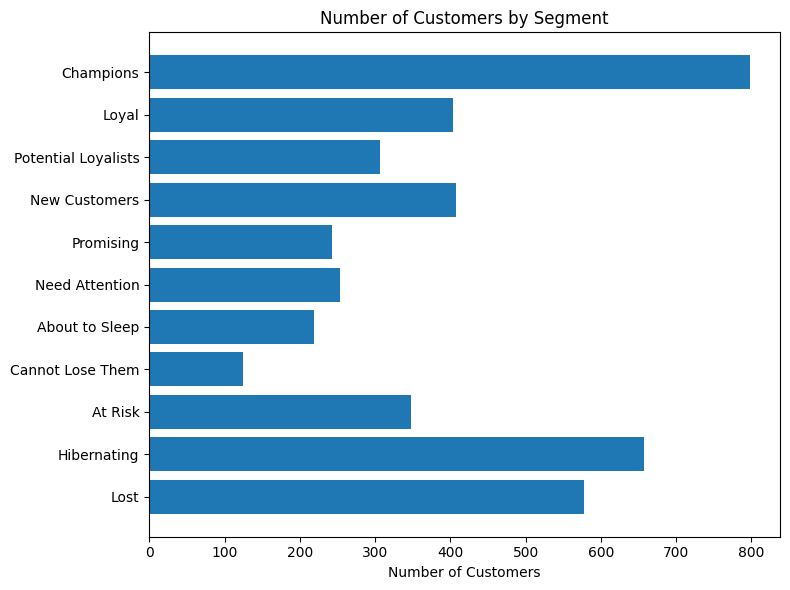

In [58]:
# Number of customers
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
ax.barh(cus_by_seg.index, cus_by_seg["CustomerCount"])
ax.invert_yaxis()
ax.set_title("Number of Customers by Segment")
ax.set_xlabel("Number of Customers")
plt.show()

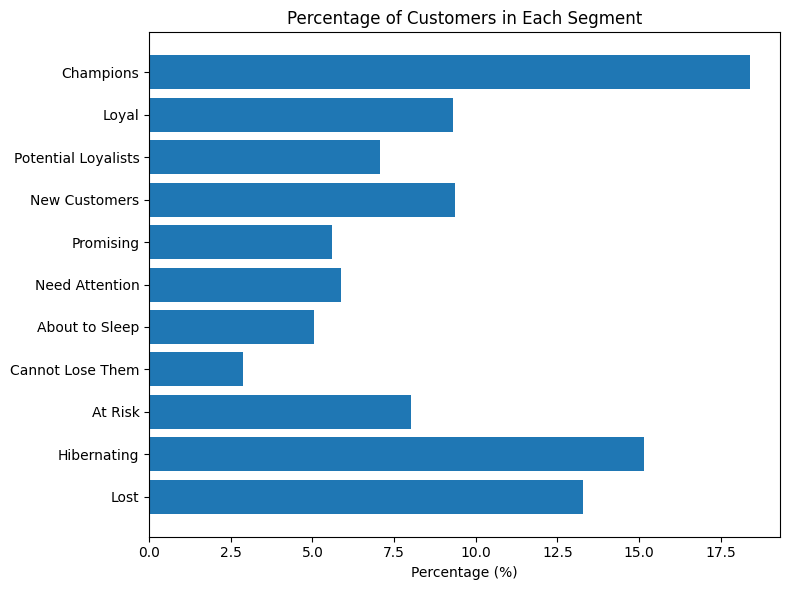

In [59]:
# Percentage
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
ax.barh(cus_by_seg.index, cus_by_seg["CustomerPercentage"])
ax.invert_yaxis()
ax.set_title("Percentage of Customers in Each Segment")
ax.set_xlabel("Percentage (%)")
plt.show()

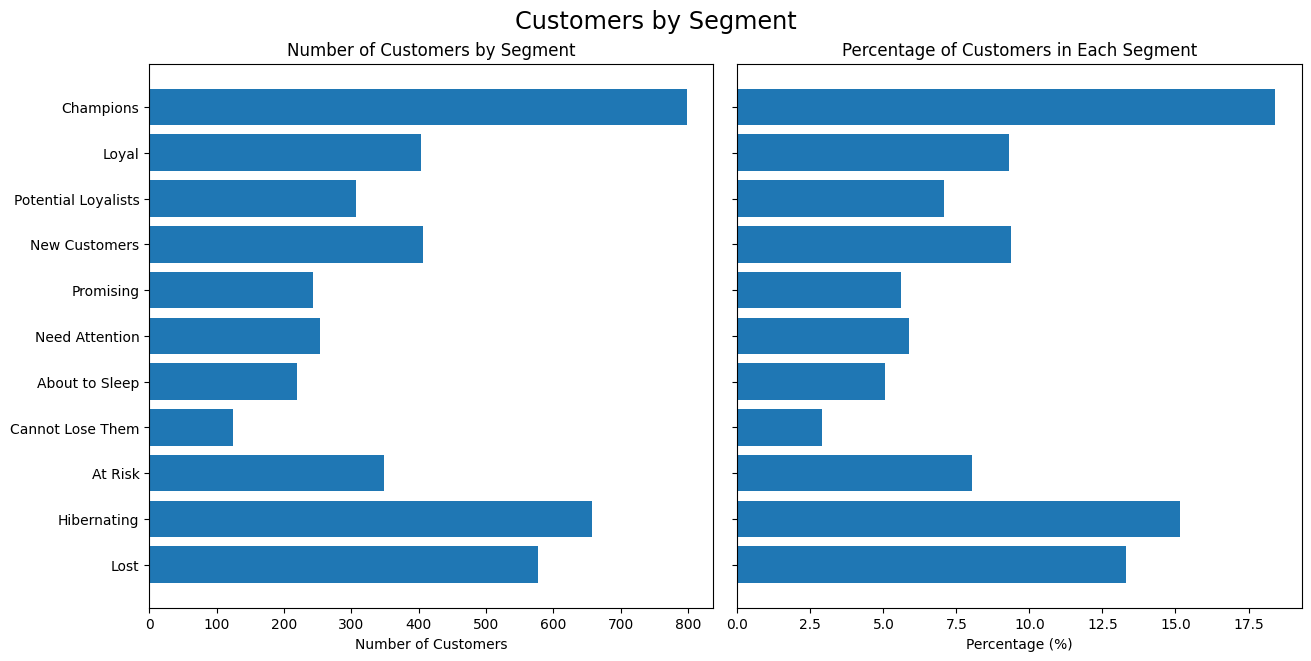

In [60]:
# Combine these plots into a single figure
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13.0, 6.5), layout="constrained")

axs_list = axs.flatten().tolist()
axs_list = cast(list[Axes], axs_list)

axs_list[0].barh(cus_by_seg.index, cus_by_seg["CustomerCount"])
axs_list[0].set_title("Number of Customers by Segment")
axs_list[0].set_xlabel("Number of Customers")

axs_list[1].barh(cus_by_seg.index, cus_by_seg["CustomerPercentage"])
axs_list[1].set_title("Percentage of Customers in Each Segment")
axs_list[1].set_xlabel("Percentage (%)")

axs_list[1].invert_yaxis()
fig.suptitle("Customers by Segment", fontsize="xx-large")

plt.show()

## Revenue by segment
### Calculations

In [61]:
# Total revenue by segment
total_by_seg = df_rfm.groupby(by="Segment", observed=True).Monetary.sum()
total_by_seg = cast(pd.Series, total_by_seg)
total_by_seg.name = "revenue"
total_by_seg.round(2)

Segment
About to Sleep           86517.91
At Risk                 692817.25
Cannot Lose Them        238878.32
Champions              5523272.40
Hibernating             263533.61
Lost                    128362.89
Loyal                  1000049.03
Need Attention          316228.10
New Customers            91929.80
Potential Loyalists     194495.14
Promising               375323.45
Name: revenue, dtype: float64

In [62]:
# Quick check
rev_new_1 = total_by_seg.loc["New Customers"]
rev_new_2 = df_rfm.loc[df_rfm["Segment"] == "New Customers", "Monetary"].sum()
assert rev_new_1 == rev_new_2
del rev_new_1
del rev_new_2

In [63]:
# Total revenue
total_rev = df_rfm["Monetary"].sum()
total_rev = cast(np.float_, total_rev)
assert np.isclose(total_rev, total_by_seg.sum())
np.round(total_rev, 2)

8911407.9

In [64]:
# Proportion
rev_prop = df_rfm.groupby(by="Segment", observed=True).Monetary.agg(lambda col: col.sum() / total_rev)
rev_prop = cast(pd.Series, rev_prop)
rev_prop.name = "proportion"
rev_prop

Segment
About to Sleep         0.009709
At Risk                0.077745
Cannot Lose Them       0.026806
Champions              0.619798
Hibernating            0.029573
Lost                   0.014404
Loyal                  0.112221
Need Attention         0.035486
New Customers          0.010316
Potential Loyalists    0.021825
Promising              0.042117
Name: proportion, dtype: float64

In [65]:
# Quick check
prop_1 = rev_prop.loc["New Customers"]
prop_2 = total_by_seg.loc["New Customers"] / df_rfm["Monetary"].sum()
assert prop_1 == prop_2
del prop_1
del prop_2

In [66]:
# Percentage
rev_perc = 100.0 * rev_prop
rev_perc = cast(pd.Series, rev_perc)
rev_perc.name = "percentage"
rev_perc.transform(lambda p: f"{p:.2f}%")

Segment
About to Sleep          0.97%
At Risk                 7.77%
Cannot Lose Them        2.68%
Champions              61.98%
Hibernating             2.96%
Lost                    1.44%
Loyal                  11.22%
Need Attention          3.55%
New Customers           1.03%
Potential Loyalists     2.18%
Promising               4.21%
Name: percentage, dtype: object

In [67]:
# A few checks
assert (rev_perc >= 0.0).all()
assert (rev_perc <= 100.0).all()
assert np.isclose(rev_perc.sum(), 100.0)

In [68]:
# Combine the above results into a DataFrame
seg_groups = df_rfm.groupby(by="Segment", observed=True)
total_rev = np.round(df_rfm["Monetary"].sum(), 2)

rev_by_seg = (
    seg_groups.Monetary.sum()
    .round(2)
    .to_frame()
    .rename(columns={"Monetary": "Revenue"})
    .assign(
        Percentage=(100.0 * seg_groups.Monetary.agg(lambda col: col.sum() / total_rev)).transform(
            lambda p: f"{p:.2f}%"
        )
    )
    .reindex(list(unique_everseen(SEGMENTS_5.values())))
)
rev_by_seg = cast(pd.DataFrame, rev_by_seg)
rev_by_seg

,Revenue,Percentage
Segment,,
Champions,5523272.40,61.98%
Loyal,1000049.03,11.22%
Potential Loyalists,194495.14,2.18%
New Customers,91929.80,1.03%
Promising,375323.45,4.21%
Need Attention,316228.10,3.55%
About to Sleep,86517.91,0.97%
Cannot Lose Them,238878.32,2.68%
At Risk,692817.25,7.77%


Use the essential parts of this code to implement a function:

In [69]:
def revenue_by_segment(df: pd.DataFrame, segments_dict: dict[str, str]) -> pd.DataFrame:
    seg_groups = df.groupby(by="Segment", observed=True)
    total_rev = np.round(df["Monetary"].sum(), 2)
    return (
        seg_groups.Monetary.sum()
        .round(2)
        .to_frame()
        .rename(columns={"Monetary": "Revenue"})
        .assign(RevenuePercentage=(100.0 * seg_groups.Monetary.agg(lambda c: c.sum() / total_rev)).round(2))
        .reindex(list(unique_everseen(segments_dict.values())))
    )

In [70]:
rev_by_seg = revenue_by_segment(df_rfm, SEGMENTS_5)
rev_by_seg

,Revenue,RevenuePercentage
Segment,,
Champions,5523272.40,61.98
Loyal,1000049.03,11.22
Potential Loyalists,194495.14,2.18
New Customers,91929.80,1.03
Promising,375323.45,4.21
Need Attention,316228.10,3.55
About to Sleep,86517.91,0.97
Cannot Lose Them,238878.32,2.68
At Risk,692817.25,7.77


### Visualization

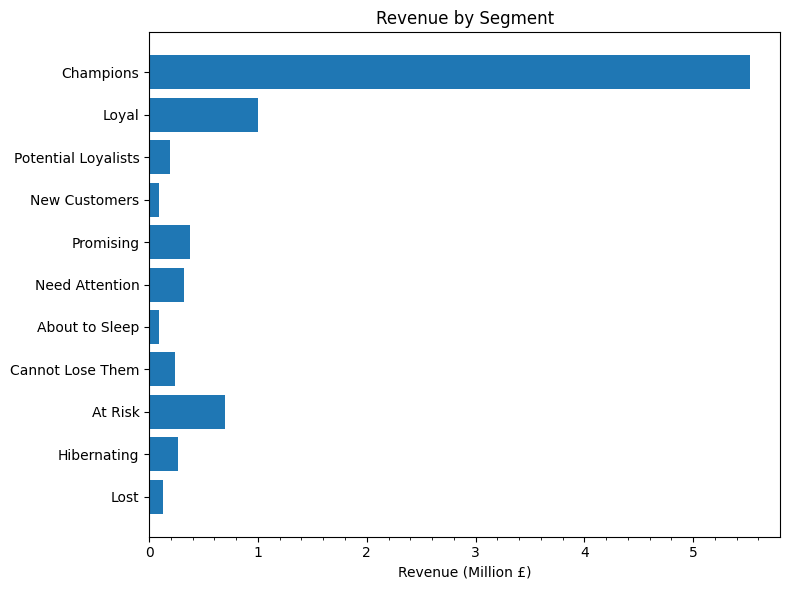

In [71]:
# Revenue
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
ax.barh(rev_by_seg.index, rev_by_seg["Revenue"] / 1e6)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.invert_yaxis()
ax.set_title("Revenue by Segment")
ax.set_xlabel("Revenue (Million £)")
plt.show()

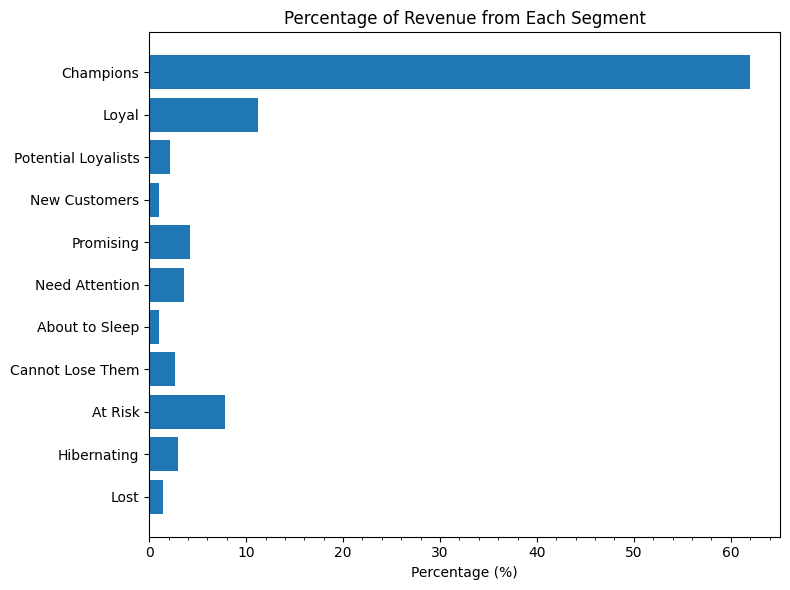

In [72]:
# Revenue percentage
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
ax.barh(rev_by_seg.index, rev_by_seg["RevenuePercentage"])
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.invert_yaxis()
ax.set_title("Percentage of Revenue from Each Segment")
ax.set_xlabel("Percentage (%)")
plt.show()

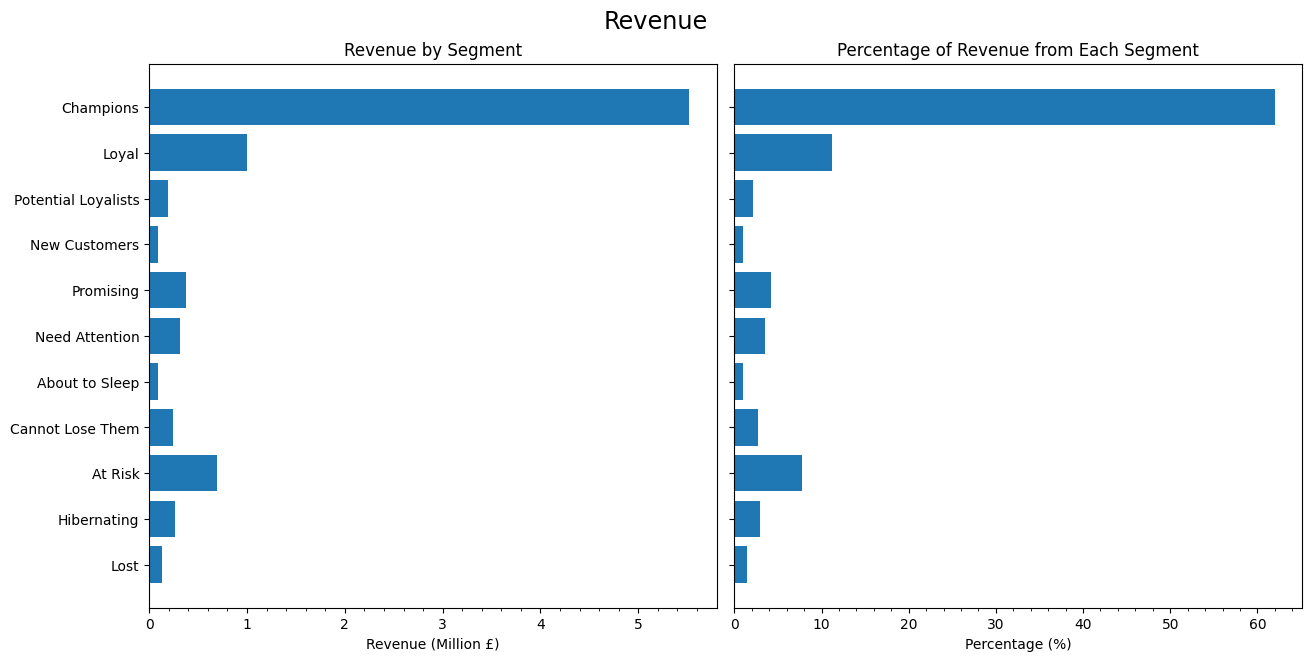

In [73]:
# Combine these plots into a single figure
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(13.0, 6.5), layout="constrained")

axs_list = axs.flatten().tolist()
axs_list = cast(list[Axes], axs_list)

axs_list[0].barh(rev_by_seg.index, rev_by_seg["Revenue"] / 1e6)
axs_list[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_list[0].set_title("Revenue by Segment")
axs_list[0].set_xlabel("Revenue (Million £)")

axs_list[1].barh(rev_by_seg.index, rev_by_seg["RevenuePercentage"])
axs_list[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_list[1].set_title("Percentage of Revenue from Each Segment")
axs_list[1].set_xlabel("Percentage (%)")

axs_list[1].invert_yaxis()
fig.suptitle("Revenue", fontsize="xx-large")

plt.show()

## A few functions

In [74]:
# Combine segment data
def get_segment_data(df: pd.DataFrame, segments_dict: dict[str, str]) -> pd.DataFrame:
    return pd.concat(
        [
            customers_by_segment(df, segments_dict),
            revenue_by_segment(df, segments_dict),
        ],
        axis=1,
    )

In [75]:
df_segment = get_segment_data(df_rfm, SEGMENTS_5)
df_segment

,CustomerCount,CustomerPercentage,Revenue,RevenuePercentage
Segment,,,,
Champions,798,18.40,5523272.40,61.98
Loyal,403,9.29,1000049.03,11.22
Potential Loyalists,307,7.08,194495.14,2.18
New Customers,407,9.38,91929.80,1.03
Promising,243,5.60,375323.45,4.21
Need Attention,254,5.86,316228.10,3.55
About to Sleep,219,5.05,86517.91,0.97
Cannot Lose Them,125,2.88,238878.32,2.68
At Risk,348,8.02,692817.25,7.77


In [76]:
# Save data in this DataFrame
out_file = file_path.parent / "segment_data.csv"
df_segment.to_csv(out_file, index=True)

Functions for creating the above plots:

In [77]:
# Path to images directory
IMG_DIR = Path.cwd().parents[1] / "img"
assert IMG_DIR.exists(), f"directory doesn't exist: {IMG_DIR}"
assert IMG_DIR.is_dir(), f"not a directory: {IMG_DIR}"

In [78]:
def plot_customers_by_segment(
    df_segment: pd.DataFrame,
    *,
    save: bool = False,
    figsize: tuple[float, float] = (13.0, 6.5),
) -> None:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize, layout="constrained")

    axs_list = axs.flatten().tolist()
    axs_list = cast(list[Axes], axs_list)

    axs_list[0].barh(df_segment.index, df_segment["CustomerCount"])
    axs_list[0].set_title("Number of Customers by Segment")
    axs_list[0].set_xlabel("Number of Customers")

    axs_list[1].barh(df_segment.index, df_segment["CustomerPercentage"])
    axs_list[1].set_title("Percentage of Customers in Each Segment")
    axs_list[1].set_xlabel("Percentage (%)")

    axs_list[1].invert_yaxis()
    fig.suptitle("Customers by Segment", fontsize="xx-large")

    if save:
        fig.savefig(IMG_DIR / "customers_by_segment.png")
    else:
        plt.show()

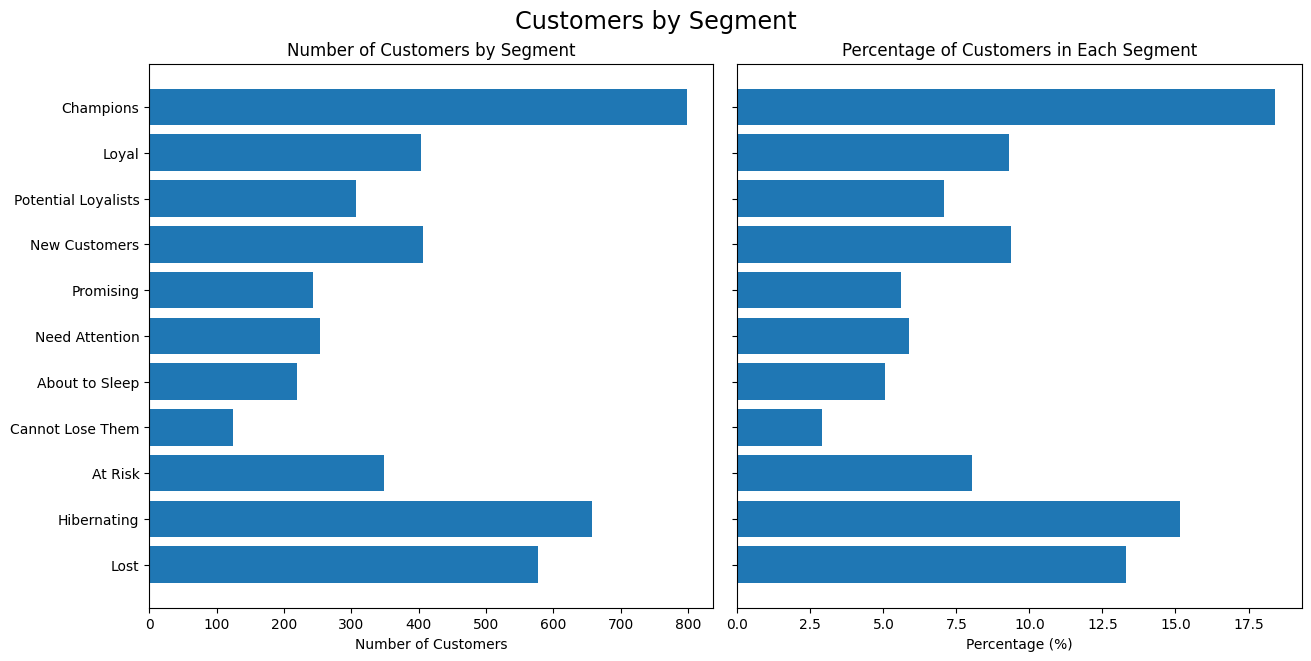

In [79]:
plot_customers_by_segment(df_segment, save=True)

In [80]:
def plot_revenue_by_segment(
    df_segment: pd.DataFrame,
    *,
    save: bool = False,
    figsize: tuple[float, float] = (13.0, 6.5),
) -> None:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize, layout="constrained")

    axs_list = axs.flatten().tolist()
    axs_list = cast(list[Axes], axs_list)

    axs_list[0].barh(df_segment.index, df_segment["Revenue"] / 1e6)
    axs_list[0].xaxis.set_minor_locator(AutoMinorLocator(5))
    axs_list[0].set_title("Revenue by Segment")
    axs_list[0].set_xlabel("Revenue (Million £)")

    axs_list[1].barh(df_segment.index, df_segment["RevenuePercentage"])
    axs_list[1].xaxis.set_minor_locator(AutoMinorLocator(5))
    axs_list[1].set_title("Percentage of Revenue from Each Segment")
    axs_list[1].set_xlabel("Percentage (%)")

    axs_list[1].invert_yaxis()
    fig.suptitle("Revenue", fontsize="xx-large")

    if save:
        fig.savefig(IMG_DIR / "revenue_by_segment.png")
    else:
        plt.show()

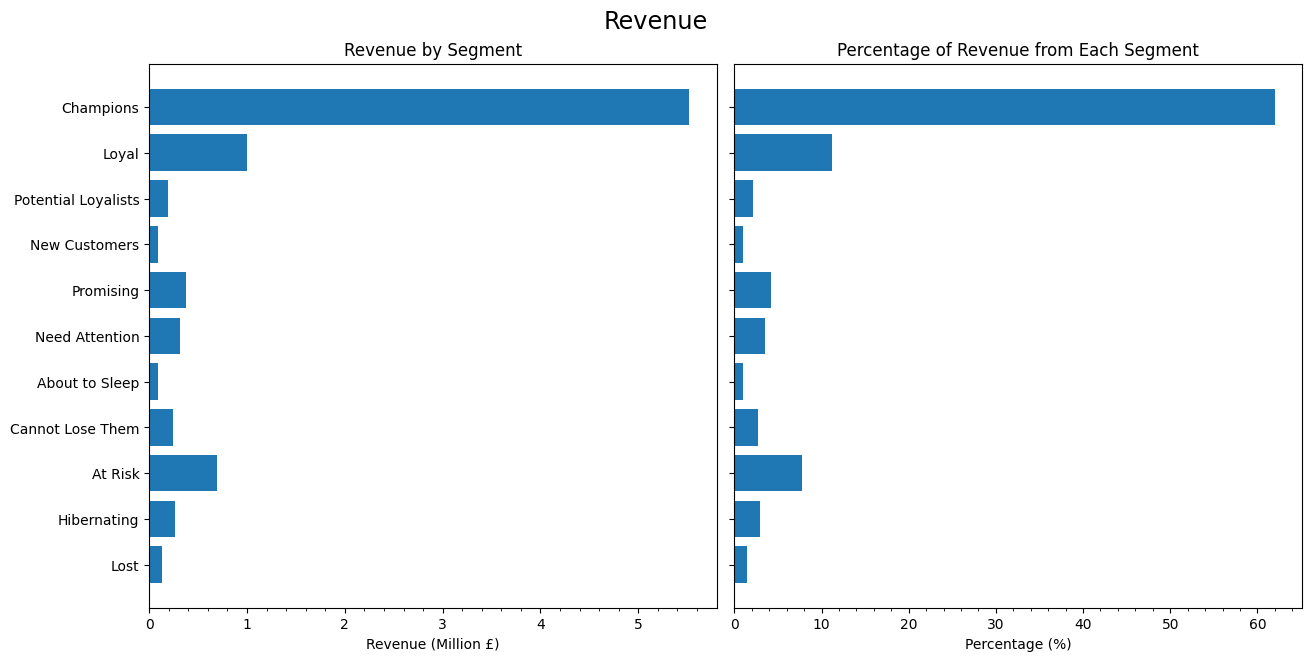

In [81]:
plot_revenue_by_segment(df_segment, save=True)

What was done above and in the last two sections can be repeated by using the
following function:

In [82]:
def compute_and_plot_segment_data(
    df: pd.DataFrame,
    segments_dict: dict[str, str],
    figsize: tuple[float, float] = (13.0, 6.5),
) -> None:
    df_segment = get_segment_data(df, segments_dict)
    out_file = DATA_DIR / "segment_data.csv"
    df_segment.to_csv(out_file, index=True)

    plot_customers_by_segment(df_segment, save=True, figsize=figsize)
    plot_revenue_by_segment(df_segment, save=True, figsize=figsize)

In [83]:
# compute_and_plot_segment_data(df_rfm, SEGMENTS_5)